In [ ]:
# Required packages
# CUDA 10.2
# torch==1.7.1
# torchvision==0.8.2
# tqdm==4.36.1
# matplotlib==2.1.0
# numpy==1.18.4


In [ ]:
from __future__ import print_function
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import os
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from time import *
%matplotlib inline

## Convolutional Neural Network (CNN) Model

In [ ]:
class DLS_Model(nn.Module):
    def __init__(self):
        super(DLS_Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 2)
        self.pool1 = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(32, 64, 2)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        self.conv3 = nn.Conv2d(64, 128, 1)
        self.pool3 = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(128 * 3 * 3, 128)
        self.fc1_bn = nn.BatchNorm1d(128)
        
        self.fc2 = nn.Linear(128, 64)
        self.fc2_bn = nn.BatchNorm1d(64)
        
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):

        x = F.relu(self.pool1((self.conv1(x))))
        x = F.relu(self.pool2((self.conv2(x))))
        x = F.relu(self.pool3((self.conv3(x))))

        #print(x.shape)
        x = x.view(-1, 128 * 3 * 3)
        
        x = F.relu(self.fc1_bn(self.fc1(x)))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2_bn(self.fc2(x)))
        x = self.fc3(x)
        return x


# Helper functions

In [ ]:
def plot_images(X,y,yp,M,N):
    f,ax = plt.subplots(M,N, sharex=True, sharey=True, figsize=(N,M*1.3))
    for i in range(M):
        for j in range(N):
            ax[i][j].imshow(1-X[i*N+j][0].cpu().numpy(), cmap="gray")
            title = ax[i][j].set_title("Pred: {}".format(yp[i*N+j].max(dim=0)[1]))
            plt.setp(title, color=('g' if yp[i*N+j].max(dim=0)[1] == y[i*N+j] else 'r'))
            ax[i][j].set_axis_off()
    plt.tight_layout()
# Source: https://www.kaggle.com/code/pratikvaishnavi/sbu-wise380rotation-securityofmachinelearn-lec3/notebook

In [ ]:
def separator(loader):
  for X,y in loader:
      X,y = X.to(device), y.to(device)
      break
  return X,y
# Source: self

## Start Training and Testing

Torch 1.11.0+cu113 CUDA 11.3
Model is using cuda


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Epoch 15: 100%|██████████| 469/469 [00:14<00:00, 33.03batch/s, loss=0.0123]


Accuracy of the network on the test images: 99 %
Let's visualize some test samples


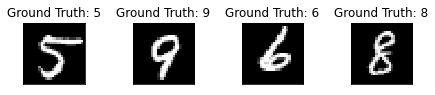

In [ ]:
def training(model, trainloader, device, optimizer, num_epoch, criterion):
    model.train()
    for epoch in range(1,num_epoch+1):
        with tqdm(trainloader, unit="batch") as tepoch:
            for inputs, labels in tepoch:
                tepoch.set_description(f"Epoch {epoch}")
                
                inputs, labels = inputs.to(device), labels.to(device) 

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                tepoch.set_postfix(loss=loss.item())
                #sleep(0.0001)
    PATH = './mnist.pth'
    torch.save(model.state_dict(), PATH)

def testing(model,testloader,device):
    model.eval()
    correct = 0
    total = 0
    error = 0
    test_loss = []
    test_accuracy = []
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            error += (predicted != labels).sum().item()
            loss = criterion(outputs, labels)
            test_loss.append(loss.item())
            test_accuracy.append((predicted == labels).sum().item() / predicted.size(0))
        avg_accuracy = correct /len(testloader.dataset)
        avg_err = error / len(testloader.dataset)
        avg_loss = loss / len(testloader.dataset)
            #total = total_correct+total_err

    print('Accuracy of the network on the test images: %d %%' % (
        100.0 * correct / total))
    avg_accuracy = correct / total
    return test_loss, test_accuracy, avg_accuracy, avg_err, avg_loss, total

    
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def show_some_image(trainloader):
    examples = enumerate(trainloader)
    batch_idx, (example_data, example_targets) = next(examples)
    fig = plt.figure(figsize=(6,6))
    for i in range(4):
        plt.subplot(1,4,i+1)
        plt.tight_layout()
        plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
        plt.title("Ground Truth: {}".format(example_targets[i]))
        plt.xticks([])
        plt.yticks([])

# specify the GPU device
use_cuda = True
print('Torch', torch.__version__, 'CUDA', torch.version.cuda)
use_cuda = use_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu");
print(f'Model is using {device}')


model = DLS_Model()
model = model.to(device)

BATCH_SIZE = 128
num_epoch = 15
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

trainloader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True, transform=transforms.Compose([
            transforms.ToTensor(),])),batch_size=BATCH_SIZE, shuffle=True)
testloader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),])),batch_size=BATCH_SIZE, shuffle=True)

'''
training(model, trainloader, device, optimizer, num_epoch, criterion)
testing_performance = testing(model,testloader,device)
print(f'Let\'s visualize some test samples')
show_some_image(testloader)

print(model)
print(f'Model Parameters {count_parameters(model)/1000000}m') 

'''
saved_model = './mnist.pth'
if os.path.exists(saved_model):
    print(f'Only Test')
    model.load_state_dict(torch.load(saved_model))
    print(f'Let\'s visualize some test samples')
    show_some_image(testloader)
    testing_performance = testing(model,testloader,device)
else:
    training(model, trainloader, device, optimizer, num_epoch, criterion)
    #training(benign_model, trainloader, device, optimizer, num_epoch, criterion)
    testing_performance = testing(model,testloader,device)
    print(f'Let\'s visualize some test samples')
    show_some_image(testloader)

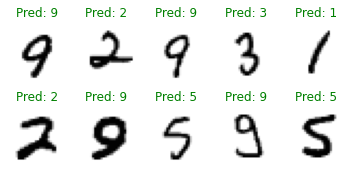

In [ ]:
# original prediction
X,y = separator(testloader)
yp = model(X)
plot_images(X, y, yp, 2, 5)

# FGSM Attack

In [ ]:
# generates perturbations using FGSM algoithm
def fgsm(model, X, y, epsilon):
    delta = torch.zeros_like(X, requires_grad=True)
    loss = nn.CrossEntropyLoss()(model(X + delta), y)
    loss.backward()
    return epsilon * delta.grad.detach().sign()

In [ ]:
def fgsmadvtesting(model,testloader, device, epsilon):
    model.eval()
    correct = 0
    total = 0
    error = 0
    adv_examples =[]
    #print(len(testloader))
    #with torch.no_grad():
    for data in testloader:
            adv_ex = []
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            delta = fgsm(model,  images, labels, epsilon)
            adv_example = images+delta, labels
            adv_examples.append(adv_example)
            outputs = model(images+delta)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            error += (predicted != labels).sum().item()
            loss = criterion(outputs, labels)
    #adv_examples.append(adv_ex)
    #print(len(adv_examples))
    avg_accuracy = correct /len(testloader.dataset)
    avg_err = error / len(testloader.dataset)
    avg_loss = loss / len(testloader.dataset)
    print('Accuracy of the network on the test images: %d %%' % (
        100.0 * correct / total))
    avg_accuracy = correct / total
    return avg_accuracy, avg_err, avg_loss, adv_examples

Source: https://pytorch.org/tutorials/beginner/fgsm_tutorial.html

# PGD Attack

In [ ]:
# generates perturbations using PGD algoithm
def pgd(model, X, y, epsilon, alpha, num_iter):
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        delta.data = (delta + X.shape[0]*alpha*delta.grad.data).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

In [ ]:
def pgdadvtesting(model,testloader, device, epsilon, alpha, num_iter):
    model.eval()
    correct = 0
    total = 0
    error = 0
    adv_examples = []
    #with torch.no_grad():
    for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            delta = pgd(model, images, labels, epsilon, alpha, num_iter)
            adv_example = images+delta, labels
            adv_examples.append(adv_example)
            outputs = model(images+delta)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            error += (predicted != labels).sum().item()
            loss = criterion(outputs, labels)
            #test_loss.append(loss.item())
            #test_accuracy.append((predicted == labels).sum().item() / predicted.size(0))
    avg_accuracy = correct /len(testloader.dataset)
    avg_err = error / len(testloader.dataset)
    avg_loss = loss / len(testloader.dataset)
            #total = total_correct+total_err

    print('Accuracy of the network on the test images: %d %%' % (
        100.0 * correct / total))
    avg_accuracy = correct / total
    return avg_accuracy, avg_err, avg_loss, adv_examples

Source: https://adversarial-ml-tutorial.org/adversarial_examples/

# Printing original, FGSM, and PGD examples

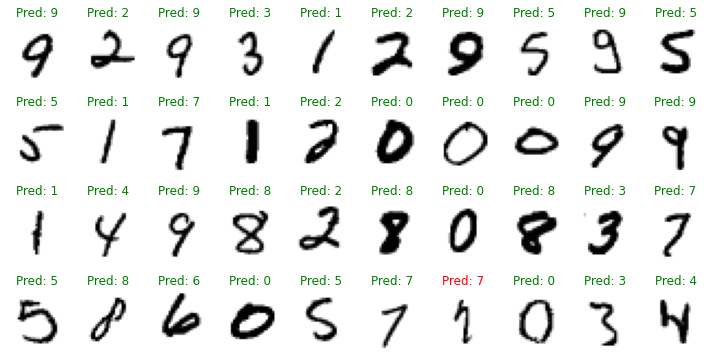

In [ ]:
# original model performance
plot_images(X, y, yp, 4, 10)

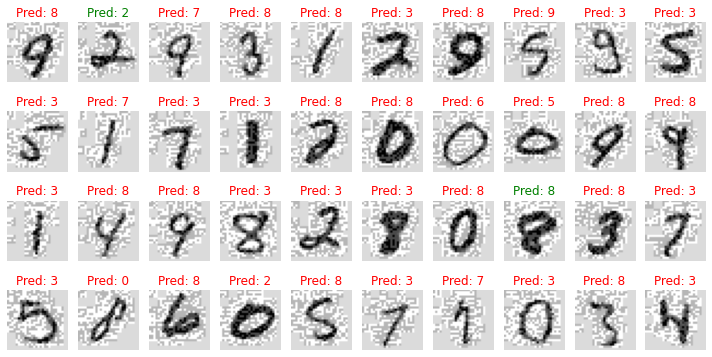

In [ ]:
# FGSM attack - model performance
delta_fgsm = fgsm(model, X, y, 0.2)
yfgsm = model(X + delta_fgsm)
plot_images(X+delta_fgsm, y, yfgsm, 4, 10)

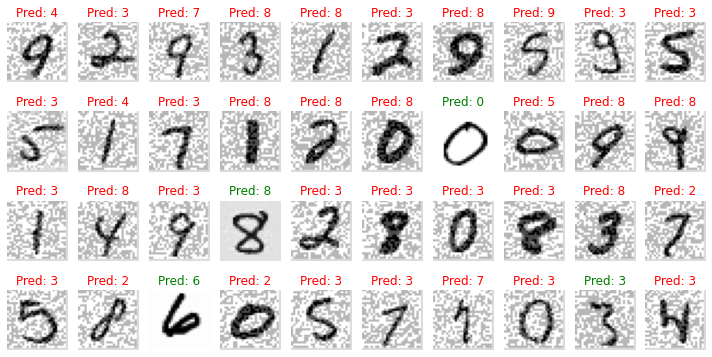

In [ ]:
# PGD attack - model performance
delta_pgd = pgd(model, X, y, 0.2, 1e4, 5)
ypgd = model(X + delta_pgd)
plot_images(X+delta_pgd, y, ypgd, 4, 10)

# FGSM attack performance

In [ ]:
epsilon =  [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
ep_test = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4]
ep_advtrain = [0.05,0.1,0.2,0.25,0.3]

In [ ]:
accuracy = []
error = []
loss = []
fgsm_advexamples = []
for e in epsilon:
  fgsm_adv_examples = fgsmadvtesting(model, testloader, device, e)
  accuracy.append(fgsm_adv_examples[0])
  error.append(fgsm_adv_examples[1])
  loss.append(fgsm_adv_examples[2])
  fgsm_advexamples.append(fgsm_adv_examples[3])
ac_fgsm = accuracy

Accuracy of the network on the test images: 51 %
Accuracy of the network on the test images: 8 %
Accuracy of the network on the test images: 3 %
Accuracy of the network on the test images: 2 %
Accuracy of the network on the test images: 2 %
Accuracy of the network on the test images: 2 %
Accuracy of the network on the test images: 3 %
Accuracy of the network on the test images: 3 %
Accuracy of the network on the test images: 3 %


In [ ]:
accuracy = []
error = []
loss = []
fgsm_advexamples = []
for e in ep_test:
  fgsm_adv_examples = fgsmadvtesting(model, testloader, device, e)
  accuracy.append(fgsm_adv_examples[0])
  error.append(fgsm_adv_examples[1])
  loss.append(fgsm_adv_examples[2])
  fgsm_advexamples.append(fgsm_adv_examples[3])
ac_fgsm_ep_test = accuracy

Accuracy of the network on the test images: 86 %
Accuracy of the network on the test images: 51 %
Accuracy of the network on the test images: 21 %
Accuracy of the network on the test images: 8 %
Accuracy of the network on the test images: 4 %
Accuracy of the network on the test images: 3 %
Accuracy of the network on the test images: 2 %
Accuracy of the network on the test images: 2 %


In [ ]:
accuracy = []
error = []
loss = []
fgsm_advexamples = []
for e in ep_advtrain:
  fgsm_adv_examples = fgsmadvtesting(model, testloader, device, e)
  accuracy.append(fgsm_adv_examples[0])
  error.append(fgsm_adv_examples[1])
  loss.append(fgsm_adv_examples[2])
  fgsm_advexamples.append(fgsm_adv_examples[3])
ac_fgsm_ep_advtrain = accuracy

Accuracy of the network on the test images: 86 %
Accuracy of the network on the test images: 51 %
Accuracy of the network on the test images: 8 %
Accuracy of the network on the test images: 4 %
Accuracy of the network on the test images: 3 %


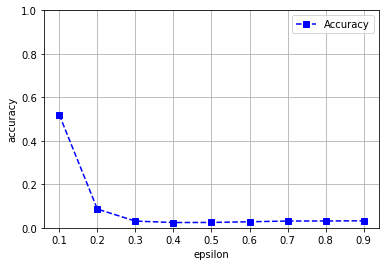

In [ ]:
plt.plot(epsilon, ac_fgsm, 'b--s', label = 'Accuracy')
#plt.plot(epsilon, error, 'b:>', label = 'Error')
plt.ylim(0,1)
plt.xlabel('epsilon')
plt.ylabel('accuracy')
plt.legend(loc='best')
plt.grid()

# PGD attack performance

In [ ]:
alpha = 5
num_iter = 30
accuracy = []
error = []
loss = []
pgd_advexamples =[]
for e in epsilon:
    pgd_adv_examples = pgdadvtesting(model,testloader, device, e, alpha, num_iter)
    accuracy.append(pgd_adv_examples[0])
    error.append(pgd_adv_examples[1]) 
    loss.append(pgd_adv_examples[2])
    pgd_advexamples.append(pgd_adv_examples[3])
ac_pgd1 = accuracy

Accuracy of the network on the test images: 75 %
Accuracy of the network on the test images: 74 %
Accuracy of the network on the test images: 74 %
Accuracy of the network on the test images: 74 %
Accuracy of the network on the test images: 74 %
Accuracy of the network on the test images: 74 %
Accuracy of the network on the test images: 74 %
Accuracy of the network on the test images: 74 %
Accuracy of the network on the test images: 74 %


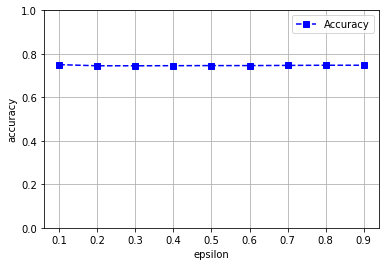

In [ ]:
plt.plot(epsilon, ac_pgd1, 'b--s', label = 'Accuracy')
#plt.plot(epsilon, error, 'b:>', label = 'Error')
plt.xlabel('epsilon')
plt.ylabel('accuracy')
plt.ylim(0,1)
plt.legend(loc='best')
plt.grid()

In [ ]:
alpha = 5
num_iter = 30
ep = 0.2
accuracy = []
error = []
loss = []
pgd_advexamples =[]
for n in range(num_iter):
    pgd_adv_examples = pgdadvtesting(model,testloader, device, ep, alpha, n)
    accuracy.append(pgd_adv_examples[0])
    error.append(pgd_adv_examples[1]) 
    loss.append(pgd_adv_examples[2])
    pgd_advexamples.append(pgd_adv_examples[3])
ac_pgd2 = accuracy

Accuracy of the network on the test images: 99 %
Accuracy of the network on the test images: 95 %
Accuracy of the network on the test images: 92 %
Accuracy of the network on the test images: 90 %
Accuracy of the network on the test images: 88 %
Accuracy of the network on the test images: 87 %
Accuracy of the network on the test images: 86 %
Accuracy of the network on the test images: 85 %
Accuracy of the network on the test images: 84 %
Accuracy of the network on the test images: 83 %
Accuracy of the network on the test images: 83 %
Accuracy of the network on the test images: 82 %
Accuracy of the network on the test images: 81 %
Accuracy of the network on the test images: 80 %
Accuracy of the network on the test images: 80 %
Accuracy of the network on the test images: 79 %
Accuracy of the network on the test images: 79 %
Accuracy of the network on the test images: 79 %
Accuracy of the network on the test images: 78 %
Accuracy of the network on the test images: 78 %
Accuracy of the netw

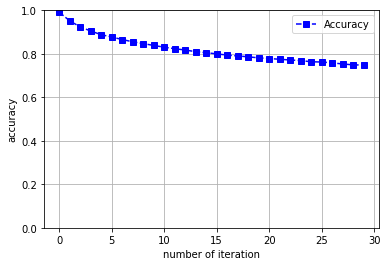

In [ ]:
plt.plot(ac_pgd2, 'b--s', label = 'Accuracy')
#plt.plot(epsilon, error, 'b:>', label = 'Error')
plt.xlabel('number of iteration')
plt.ylabel('accuracy')
plt.ylim(0,1)
plt.legend(loc='best')
plt.grid()

In [ ]:
alpha = [1, 2, 3, 4, 5, 10, 20]
num_iter = 9
ep = 0.2
accuracy = []
error = []
loss = []
pgd_advexamples =[]
for a in alpha:
    pgd_adv_examples = pgdadvtesting(model,testloader, device, ep, a, num_iter)
    accuracy.append(pgd_adv_examples[0])
    error.append(pgd_adv_examples[1]) 
    loss.append(pgd_adv_examples[2])
    pgd_advexamples.append(pgd_adv_examples[3])
ac_pgd3 = accuracy

Accuracy of the network on the test images: 90 %
Accuracy of the network on the test images: 87 %
Accuracy of the network on the test images: 86 %
Accuracy of the network on the test images: 85 %
Accuracy of the network on the test images: 83 %
Accuracy of the network on the test images: 79 %
Accuracy of the network on the test images: 75 %


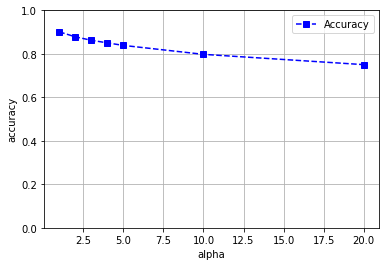

In [ ]:
plt.plot(alpha, ac_pgd3, 'b--s', label = 'Accuracy')
#plt.plot(epsilon, error, 'b:>', label = 'Error')
plt.xlabel('alpha')
plt.ylabel('accuracy')
plt.ylim(0,1)
plt.legend(loc='best')
plt.grid()

In [ ]:
alpha = 5
num_iter = 30
accuracy = []
error = []
loss = []
pgd_advexamples =[]
for e in ep_test:
    pgd_adv_examples = pgdadvtesting(model,testloader, device, e, alpha, num_iter)
    accuracy.append(pgd_adv_examples[0])
    error.append(pgd_adv_examples[1]) 
    loss.append(pgd_adv_examples[2])
    pgd_advexamples.append(pgd_adv_examples[3])
ac_pgd_ep_test = accuracy

Accuracy of the network on the test images: 81 %
Accuracy of the network on the test images: 75 %
Accuracy of the network on the test images: 74 %
Accuracy of the network on the test images: 74 %
Accuracy of the network on the test images: 74 %
Accuracy of the network on the test images: 74 %
Accuracy of the network on the test images: 74 %
Accuracy of the network on the test images: 74 %


In [ ]:
alpha = 5
num_iter = 30
accuracy = []
error = []
loss = []
pgd_advexamples =[]
for e in ep_advtrain:
    pgd_adv_examples = pgdadvtesting(model,testloader, device, e, alpha, num_iter)
    accuracy.append(pgd_adv_examples[0])
    error.append(pgd_adv_examples[1]) 
    loss.append(pgd_adv_examples[2])
    pgd_advexamples.append(pgd_adv_examples[3])
ac_pgd_ep_advtrain = accuracy

Accuracy of the network on the test images: 81 %
Accuracy of the network on the test images: 75 %
Accuracy of the network on the test images: 74 %
Accuracy of the network on the test images: 74 %
Accuracy of the network on the test images: 74 %


In [ ]:
testing_performance_model = testing(model,testloader,device)
original_model = model
original_model = original_model.to(device)
testing_performance_model = testing(original_model,testloader,device)

Accuracy of the network on the test images: 99 %
Accuracy of the network on the test images: 99 %


# FGSM adversarial training

In [ ]:
def fgsm_advtraining(model, trainloader, device, optimizer, num_epoch, criterion):
    print(len(trainloader))
    adv_examples = []
    model.train()
    train_loss = []
    total_correct_adv = []
    total_loss_adv = []
    total_loss_original  = []
    total_correct_original = []
    for epoch in range(1,num_epoch+1):
        with tqdm(trainloader, unit="batch") as tepoch:
            for inputs, labels in tepoch:
                tepoch.set_description(f"Epoch {epoch}")
                
                inputs, labels = inputs.to(device), labels.to(device) 
                # generating and training with following epsilon-based examples
                ep_advtrrain = [0.05,0.1,0.2,0.25,0.3]
                for e in ep_advtrain:
                    delta = fgsm(model, inputs, labels, e)
                    adv_example = inputs+delta, labels
                    adv_examples.append(adv_example)
                    #print(len(adv_examples))
                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # adversarial training
                    # forward + backward + optimize
                    outputs = model(inputs+delta)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()
                      
                    tepoch.set_postfix(loss=loss.item())

                # original sample training    
                optimizer.zero_grad()
                  # forward + backward + optimize
                outputs_original = model(inputs)
                loss_original = criterion(outputs_original, labels)
                loss_original.backward()
                optimizer.step()
                
                tepoch.set_postfix(loss=loss.item())
                #sleep(0.0001)
    train_loss.append(loss)
    print(len(adv_examples))
    PATH = './mnist.pth'
    model_robust = model
    torch.save(model_robust.state_dict(), PATH)
    return model_robust, adv_examples, train_loss
# Source: self

In [ ]:
#new_model_trained_fgsm_aes, new_fgsm_adv_examples, untrained_train_loss = fgsm_advtraining(untrained_model, trainloader, device, optimizer, num_epoch, criterion)
model_trained_fgsm_aes, fgsm_adv_examples, trained_train_loss = fgsm_advtraining(model, trainloader, device, optimizer, num_epoch, criterion)

469


Epoch 15: 100%|██████████| 469/469 [00:42<00:00, 11.08batch/s, loss=0.301]


35175


# Performance of FGSM attack on FGSM AE trained model

In [ ]:
# fgsm trained model, test on fgsm model
accuracy = []
error = []
loss = []
fgsm_advexamples = []
#training(untrained_model, trainloader, device, optimizer, num_epoch, criterion)
for e in ep_test:
  fgsm_adv_examples = fgsmadvtesting(model_trained_fgsm_aes, testloader, device, e)
  accuracy.append(fgsm_adv_examples[0])
  error.append(fgsm_adv_examples[1])
  loss.append(fgsm_adv_examples[2])
  fgsm_advexamples.append(fgsm_adv_examples[3])
fgsm_trained_model_test = accuracy

Accuracy of the network on the test images: 97 %
Accuracy of the network on the test images: 95 %
Accuracy of the network on the test images: 93 %
Accuracy of the network on the test images: 91 %
Accuracy of the network on the test images: 89 %
Accuracy of the network on the test images: 87 %
Accuracy of the network on the test images: 83 %
Accuracy of the network on the test images: 77 %


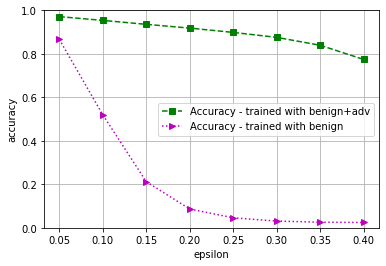

In [ ]:
plt.plot(ep_test, fgsm_trained_model_test, 'g--s', label = 'Accuracy - trained with benign+adv')
#plt.plot(ep_test, ac_fgsm_model_untrained, 'r:>', label = 'Accuracy - untrained adv')
plt.plot(ep_test, ac_fgsm_ep_test, 'm:>', label = 'Accuracy - trained with benign')
plt.xlabel('epsilon')
plt.ylabel('accuracy')
plt.ylim(0,1)
plt.legend(loc='best')
plt.grid()

In [ ]:
testing_performance_model = testing(model,testloader,device)
testing_performance_model = testing(original_model,testloader,device)
testing_performance_model = testing(model_trained_fgsm_aes,testloader,device)

Accuracy of the network on the test images: 98 %
Accuracy of the network on the test images: 98 %
Accuracy of the network on the test images: 98 %


# PGD adversarial training

In [ ]:
def pgd_advtraining(model, trainloader, device, optimizer, num_epoch, criterion):
    print(len(trainloader))
    #adv_examples = []
    model.train()
    train_loss = []
    alpha = 5
    num_iter = 5
    for epoch in range(1,num_epoch+1):
        with tqdm(trainloader, unit="batch") as tepoch:
            for inputs, labels in tepoch:
                tepoch.set_description(f"Epoch {epoch}")
                
                inputs, labels = inputs.to(device), labels.to(device) 
                # adversarial example generation using specific epsilon values
                epsilon_advtrain = [0.05,0.1,0.2,0.25,0.3]
                for e in epsilon_advtrain:
                    delta = pgd(model, inputs, labels, e, alpha, num_iter)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # adversarial training
                    # forward + backward + optimize
                    outputs = model(inputs+delta)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()
                      
                    tepoch.set_postfix(loss=loss.item())
                    
                optimizer.zero_grad()
                
                # original sample training
                  # forward + backward + optimize
                outputs_original = model(inputs)
                loss_original = criterion(outputs_original, labels)
                loss_original.backward()
                optimizer.step()
                
                tepoch.set_postfix(loss=loss.item())
                #sleep(0.0001)
    train_loss.append(loss)
    #print(len(adv_examples))
    PATH = './mnist.pth'
    model_robust = model
    torch.save(model_robust.state_dict(), PATH)
    return model_robust, train_loss
# Source: self

In [ ]:
model_trained_pgd_aes, trained_train_loss_pgd = pgd_advtraining(model, trainloader, device, optimizer, num_epoch, criterion)

469


Epoch 15: 100%|██████████| 469/469 [01:15<00:00,  6.25batch/s, loss=0.241]


In [ ]:
testing_performance_model = testing(model,testloader,device)
testing_performance_original_model = testing(original_model,testloader,device)
testing_performance_trained_fgsm_model = testing(model_trained_fgsm_aes,testloader,device)
testing_performance_trained_pgd_model = testing(model_trained_pgd_aes,testloader,device)

Accuracy of the network on the test images: 99 %
Accuracy of the network on the test images: 99 %
Accuracy of the network on the test images: 99 %
Accuracy of the network on the test images: 99 %


# Performance of PGD attack on PGD AE trained model

In [ ]:
# pgd trained model, test on pgd model
accuracy = []
error = []
loss = []
pgd_advexamples = []
#training(untrained_model, trainloader, device, optimizer, num_epoch, criterion)
for e in ep_test:
  #pgd_adv_examples = pgdadvtesting(model_trained_pgd_aes, testloader, device, e, alpha, num_iter)
  pgd_adv_examples = pgdadvtesting(model_trained_pgd_aes,testloader, device, e, alpha, num_iter)
  accuracy.append(pgd_adv_examples[0])
  error.append(pgd_adv_examples[1])
  loss.append(pgd_adv_examples[2])
  pgd_advexamples.append(pgd_adv_examples[3])
pgd_trained_model_test = accuracy

Accuracy of the network on the test images: 98 %
Accuracy of the network on the test images: 95 %
Accuracy of the network on the test images: 94 %
Accuracy of the network on the test images: 93 %
Accuracy of the network on the test images: 93 %
Accuracy of the network on the test images: 92 %
Accuracy of the network on the test images: 92 %
Accuracy of the network on the test images: 92 %


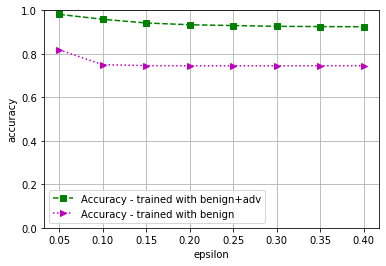

In [ ]:
plt.plot(ep_test, pgd_trained_model_test, 'g--s', label = 'Accuracy - trained with benign+adv')
#plt.plot(ep_test, ac_fgsm_model_untrained, 'r:>', label = 'Accuracy - untrained adv')
plt.plot(ep_test, ac_pgd_ep_test, 'm:>', label = 'Accuracy - trained with benign')
plt.xlabel('epsilon')
plt.ylabel('accuracy')
plt.ylim(0,1)
plt.legend(loc='best')
plt.grid()

# Performance of FGSM attack on PGD AE trained model
# and
# Performance of PGD attack on FGSM AE trained model

In [ ]:
# pgd trained model, test on fgsm model
accuracy = []
for e in ep_test: 
  pgd_on_fgsm_adv_examples = pgdadvtesting(model_trained_fgsm_aes,testloader, device, e, alpha, num_iter)
  accuracy.append(pgd_on_fgsm_adv_examples[0])
ac_pgd_on_fgsm = accuracy

Accuracy of the network on the test images: 98 %
Accuracy of the network on the test images: 95 %
Accuracy of the network on the test images: 94 %
Accuracy of the network on the test images: 93 %
Accuracy of the network on the test images: 93 %
Accuracy of the network on the test images: 92 %
Accuracy of the network on the test images: 92 %
Accuracy of the network on the test images: 92 %


In [ ]:
# fgsm trained model, test on pgd model
accuracy = []
for e in ep_test:
  fgsm_on_pgd_adv_examples = fgsmadvtesting(model_trained_pgd_aes, testloader, device, e)
  accuracy.append(fgsm_on_pgd_adv_examples[0])
ac_fgsm_on_pgd = accuracy

Accuracy of the network on the test images: 98 %
Accuracy of the network on the test images: 97 %
Accuracy of the network on the test images: 95 %
Accuracy of the network on the test images: 93 %
Accuracy of the network on the test images: 91 %
Accuracy of the network on the test images: 89 %
Accuracy of the network on the test images: 86 %
Accuracy of the network on the test images: 75 %


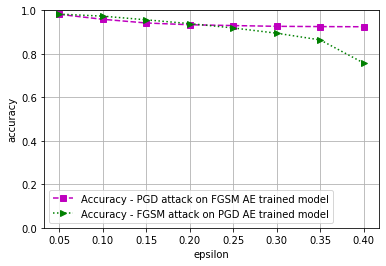

In [ ]:
plt.plot(ep_test, ac_pgd_on_fgsm, 'm--s', label = 'Accuracy - PGD attack on FGSM AE trained model')
#plt.plot(ep_test, ac_fgsm_model_untrained, 'r:>', label = 'Accuracy - untrained adv')
plt.plot(ep_test, ac_fgsm_on_pgd , 'g:>', label = 'Accuracy - FGSM attack on PGD AE trained model')
plt.xlabel('epsilon')
plt.ylabel('accuracy')
plt.ylim(0,1)
plt.legend(loc='best')
plt.grid()

# Plot of training loss

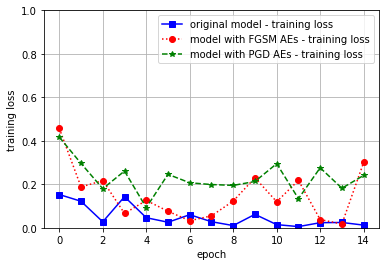

In [ ]:
plt.plot(original_training_loss, 'b-s', label = 'original model - training loss')
plt.plot(fgsm_training_loss, 'r:o', label = 'model with FGSM AEs - training loss')
plt.plot(pgd_training_loss, 'g--*', label = 'model with PGD AEs - training loss')
plt.xlabel('epoch')
plt.ylabel('training loss')
plt.ylim(0,1)
plt.legend(loc='best')
plt.grid()